In [1]:
import numpy as np
import os
import mne
import pickle
import pandas as pd
from mat73 import loadmat
import matplotlib.pyplot as plt
import osl
import yaml

In [83]:
dataset_path = "/gpfs2/well/woolrich/projects/disp_csaky/opm_rich/reading_only/20230314_144007_meg.fif"
raw = mne.io.read_raw_fif(dataset_path, preload=True)

In [6]:
# print channel types
print(raw.get_channel_types())

['stim', 'stim', 'stim', 'stim', 'stim', 'stim', 'stim', 'stim', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'ref_meg', 'ref_meg', 'ref_meg', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag',

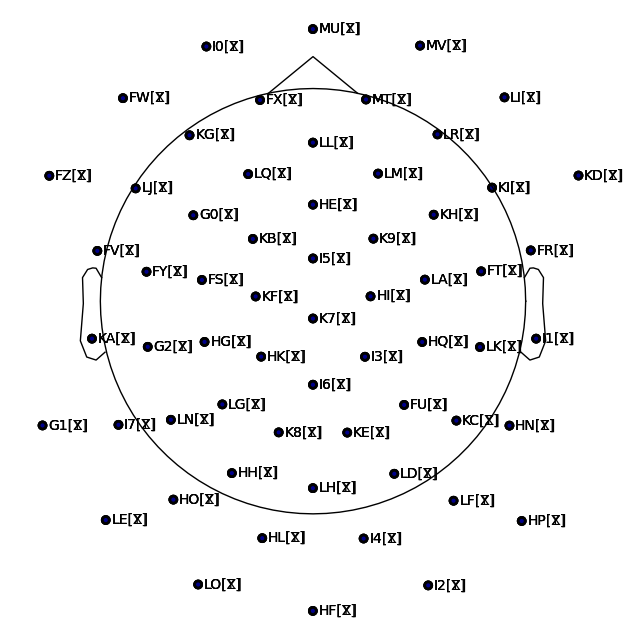

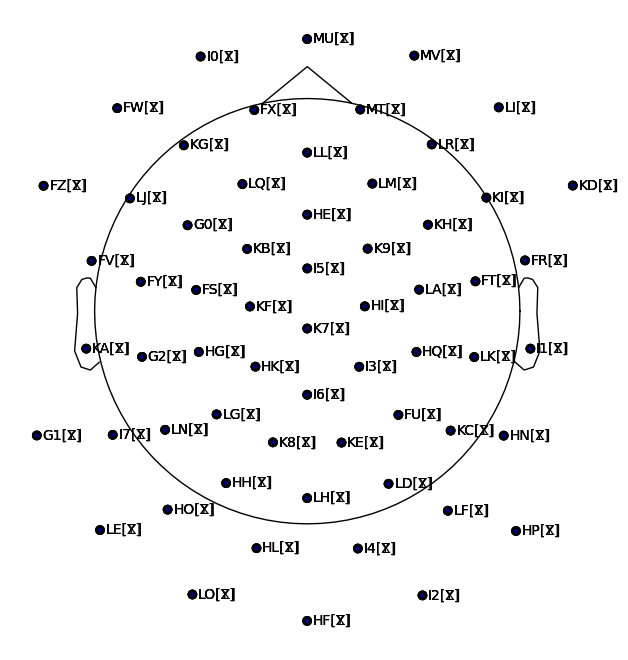

In [16]:
raw.plot_sensors(show_names=True)

In [160]:
# OSL preproc pipeline
outdir = '/well/woolrich/projects/disp_csaky/opm_rich/reading_only/highpass_4hz/'
#- bad_channels:   {picks: 'mag', significance_level: 0.4}
#   - load_bad_channels: {bad_file: '/well/woolrich/projects/disp_csaky/opm_rich/reading_only/highpass_4hz/bad_channels.txt'}

config_text = """
meta:
  event_codes:
    words/hungry: 2
    words/tired: 3
    words/thirsty: 4
    words/toilet: 5
    words/pain: 6
preproc:
  - drop_channels:  {ch_names: ['FZ[X]', 'G1[Z]', 'G1[Y]', 'G1[X]', 'K9[X]', 'KF[Y]', 'KA[X]', 'KA[Y]', 'KA[Z]', 'LE[X]', 'LE[Y]', 'LE[Z]']}
  - filter:         {l_freq: 4, h_freq: 25, method: 'iir', iir_params: {order: 5, ftype: butter}}
  - resample:       {sfreq: 100}
  - bad_segments:   {segment_len: 200, picks: 'mag', significance_level: 0.1}
  - bad_segments:   {segment_len: 400, picks: 'mag', significance_level: 0.1}
  - bad_segments:   {segment_len: 600, picks: 'mag', significance_level: 0.1}
  - bad_segments:   {segment_len: 800, picks: 'mag', significance_level: 0.1}
  - ica_raw:        {picks: 'mag', n_components: 64}
"""

In [106]:
# run OSL preprocessing
config = yaml.load(config_text, Loader=yaml.FullLoader)
dataset = osl.preprocessing.run_proc_chain(config,
                                           dataset_path,
                                           outdir=outdir,
                                           overwrite=True,
                                           gen_report=True)

20230314_144007_meg : OSL osl_logger: handler 'console' level set to 'INFO'
20230314_144007_meg : logging to file: /well/woolrich/projects/disp_csaky/opm_rich/reading_only/highpass_4hz/20230314_144007_meg/logs/20230314_144007_meg_preproc_raw.log
20230314_144007_meg : 2023-03-23 16:51:25 : Starting OSL Processing
20230314_144007_meg : input : /gpfs2/well/woolrich/projects/disp_csaky/opm_rich/reading_only/20230314_144007_meg.fif
20230314_144007_meg : IMPORTING: /gpfs2/well/woolrich/projects/disp_csaky/opm_rich/reading_only/20230314_144007_meg.fif
20230314_144007_meg : Detected fif file format, using: mne.io.read_raw_fif
20230314_144007_meg : MNE Stage - raw.drop_channels
20230314_144007_meg : userargs: {'ch_names': ['FZ[X]', 'G1[Z]', 'G1[Y]', 'G1[X]', 'K9[X]', 'KF[Y]', 'KA[X]', 'KA[Y]', 'KA[Z]', 'LE[X]', 'LE[Y]', 'LE[Z]']}
20230314_144007_meg : MNE Stage - raw.filter
20230314_144007_meg : userargs: {'l_freq': 4, 'h_freq': 25, 'method': 'iir', 'iir_params': {'order': 5, 'ftype': 'butter'}

In [107]:
raw_proc = dataset['raw']
raw_proc = raw_proc.pick('mag')

In [108]:
print(raw_proc.info['bads'])
len(raw_proc.ch_names)

[]


171

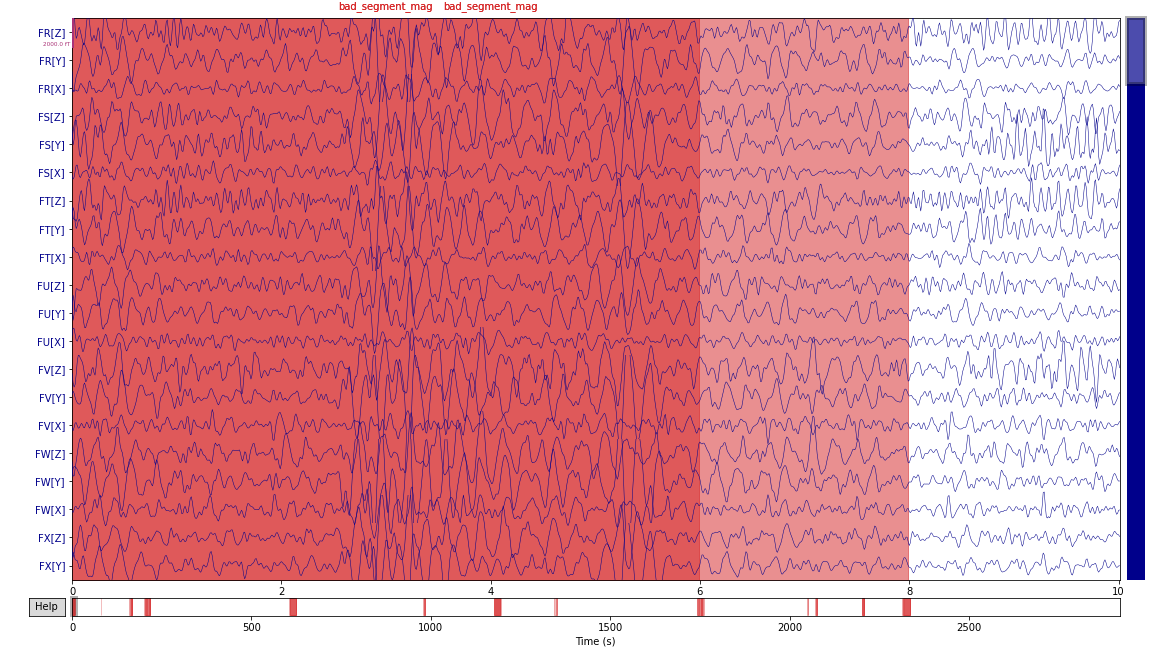

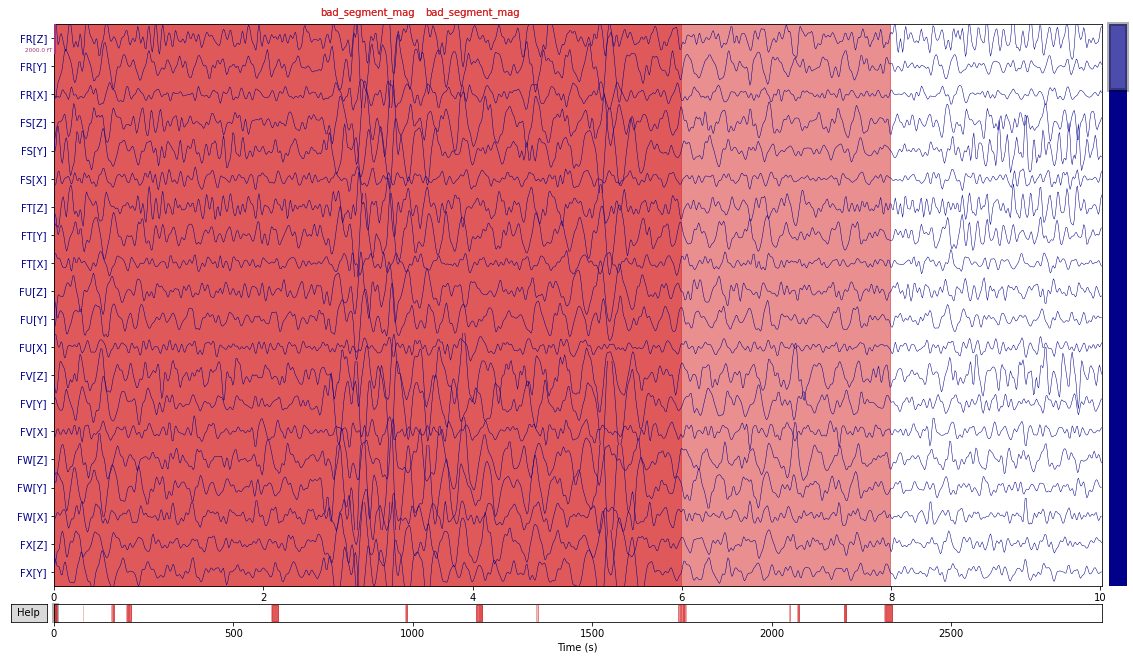

In [109]:
# plot the data
raw_proc.plot()

In [110]:
# select x, y, z channels
x_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[X]' in c]
y_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[Y]' in c]
z_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[Z]' in c]

In [111]:
ica = dataset['ica']

In [112]:
# Get components and sources
comps = ica.get_components()
ica_sources = ica.get_sources(raw_proc).get_data()

In [113]:
ch_names = [c for c in raw_proc.ch_names if '[Z]' in c]
info_z = raw_proc.copy().pick_channels(ch_names).info

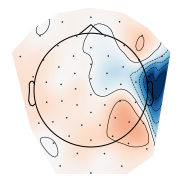

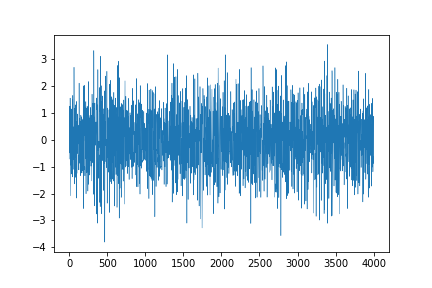

In [156]:
# plot component timeseries and topographies
%matplotlib inline
index = 38

# set figsize
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
mne.viz.plot_topomap(comps[z_inds, index], info_z, axes=ax)

%matplotlib widget
plt.plot(ica_sources[index][40000:44000], linewidth=0.5)

In [157]:
# set components to exclude
ica.exclude = [4, 5, 15]

In [158]:
# apply ica to the data
raw_proc = ica.apply(raw_proc)

In [161]:
# save data
raw_proc.save(outdir + 'raw_preproc.fif')

<ipython-input-161-231de57478cd>:2: RuntimeWarning: This filename (/well/woolrich/projects/disp_csaky/opm_rich/reading_only/highpass_4hz/raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_proc.save(outdir + 'raw_preproc.fif')
